# Apprentissage non supervisé (clustering)
## 10% de dataset `20newsgroups` **sans** stopwords

In [144]:
# Importation de librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import sys
sys.path.append('../') 

from iads import Classifiers as classif

from iads import utils as ut

from iads import evaluation as ev

from iads import Clustering as clust

from iads.vectorization import get_bow_vect, get_tfidf_vect

from iads.preprocessing import get_corpus, clean_news, lemmatize_filter

import iads.clustering_eval as ce

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2
%matplotlib inline  

sns.set_theme()
plt.rcParams['font.family'] = 'Proxima Nova'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Chargement de données et prétraitement

In [99]:
newsgroups_df = pd.read_csv("data/sample.csv")
stop_words_df = pd.read_csv("data/stopwords.csv")
stopwords = stop_words_df["stopword"].values.tolist()

news_no_stopwords = clean_news(newsgroups_df, stopwords, True, True)
news_no_stopwords = lemmatize_filter(news_no_stopwords, 3, 10)
news_no_stopwords
corpus = get_corpus(news_no_stopwords)
news_no_stopwords

Number of Nans 48


,Message index,target,label,messages
0,0,0,alt.atheism,law seem value criminal life victim life islam...
1,1,0,alt.atheism,com bill newsgroups alt atheism organization s...
2,2,0,alt.atheism,true believer die belief jesus jim jones well ...
3,3,0,alt.atheism,knowing keith expect bring better oil well dry
4,4,0,alt.atheism,film medium alternative movie source may book ...
...,...,...,...,...
1810,1879,19,comp.os.ms-windows.misc,think mistaken thinking tom atheist find athei...
1811,1881,19,comp.os.ms-windows.misc,would religious belief therefore feel comforta...
1812,1882,19,comp.os.ms-windows.misc,extremely good example evidence every time rig...
1813,1883,19,comp.os.ms-windows.misc,vol part ocean translation turkish writing sai...


Avant de procéder à l'évaluation des clusters, il faut remarquer que la dimension est très grande et la distance euclidienne souffre d'un fléau de dimension : les points deviennent équidistants et par conséquent clustering KMeans basé sur la distance euclidinne aura la mauvaise performance.

Text(0.5, 0.98, 'Distribution des distances entres les points')

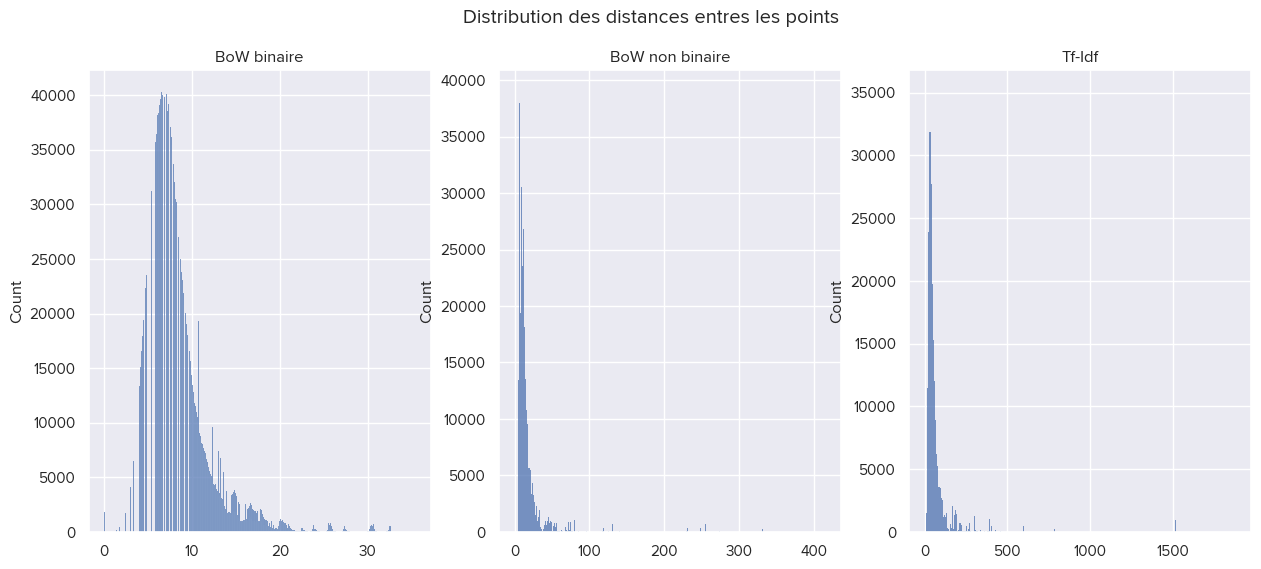

In [127]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

news_desc = get_bow_vect(news_no_stopwords, corpus, binary=True)
distances = pairwise_distances(news_desc).flatten()
sns.histplot(distances, ax=ax1)
ax1.set_title("BoW binaire")


news_desc = get_bow_vect(news_no_stopwords, corpus, binary=False)
distances = pairwise_distances(news_desc).flatten()
sns.histplot(distances, ax=ax2)
ax2.set_title("BoW non binaire")

news_desc = get_tfidf_vect(news_no_stopwords, corpus)
distances = pairwise_distances(news_desc).flatten()
sns.histplot(distances, ax=ax3)
ax3.set_title("Tf-Idf")

fig.suptitle("Distribution des distances entres les points")

Si on prend $k=20$ pour KMeans (et, par exemple, la vectorisation bow binaire), alors on obtient la distribution des points et des targets très déséquilibrés : la plupart des points (messages) sont dans le même cluster. Cela est la conséquence directe du fléau de dimension.

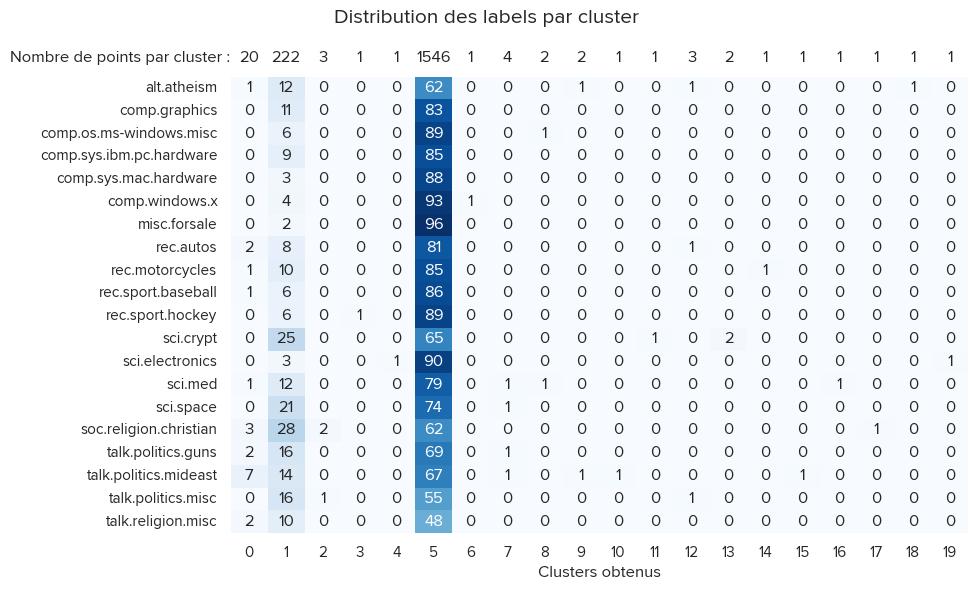

In [142]:
news_desc = get_bow_vect(news_no_stopwords, corpus, binary=True).toarray()
centroids, affectation = clust.kmoyennes(20, news_desc, 0, 1000, False)
affectation = ce.predict_label(affectation)
fig = ce.distribution_target(news_no_stopwords['target'].values, affectation, news_no_stopwords['label'].values)

Afin de battre ce problème, on effectue la réduction de dimensionnalité à l'aide de PCA. Il nous faut de déterminer le nombre de composants qui permettent d'expliquer, par exemple, $95\%$ de la variance. Vu que PCA est sensible à l'échelle des vecteurs, on doir également normalizer chaque vecteur (message) pour qu'il soit de norme 1.

In [135]:
news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=True))
print("Bow binaire, n_components:", ce.get_n_components_PCA(news_desc, 0.95))

news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=False))
print("Bow non binaire, n_components:", ce.get_n_components_PCA(news_desc, 0.95))

news_desc = normalize(get_tfidf_vect(news_no_stopwords, corpus))
print("Tf-Idf, n_components:", ce.get_n_components_PCA(news_desc, 0.95))

Bow binaire, n_components: 1132
Bow non binaire, n_components: 1109
Tf-Idf, n_components: 1249


In [153]:
bow_bin_pca, bow_non_bin_pca, tfidf_pca = 1132, 1109, 1249

Text(0.5, 0.98, 'Distribution des distances entres les points')

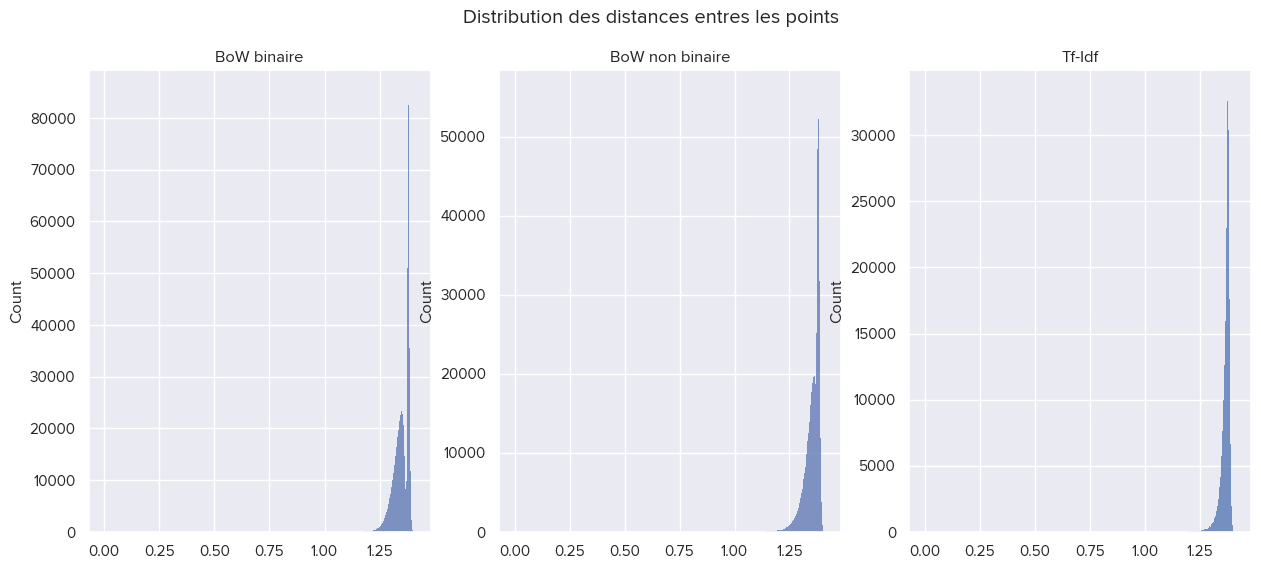

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=True))
model = PCA(n_components=bow_bin_pca)
m_pca = model.fit_transform(news_desc)
distances = pairwise_distances(m_pca).flatten()
sns.histplot(distances, ax=ax1)
ax1.set_title("BoW binaire")

news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=False))
model = PCA(n_components=bow_non_bin_pca)
m_pca = model.fit_transform(news_desc)
distances = pairwise_distances(m_pca).flatten()
sns.histplot(distances, ax=ax2)
ax2.set_title("BoW non binaire")

news_desc = normalize(get_tfidf_vect(news_no_stopwords, corpus))
model = PCA(n_components=tfidf_pca)
m_pca = model.fit_transform(news_desc)
distances = pairwise_distances(m_pca).flatten()
sns.histplot(distances, ax=ax3)
ax3.set_title("Tf-Idf")

fig.suptitle("Distribution des distances entres les points")

Ensuite, pour comparer, on applique KMeans sur ces données réduites. On verra que la répartition par cluster est beaucoup mieux qu'avant PCA. On va donc procéder avec la réduction de la dimensionnalité. Afin de comprendre les clusters on regardera également les nuages de mots par cluster

### Bag-of-words binaire
La distribution des points par cluster est beaucoup mieux qu'avant PCA. On va donc procéder avec la réduction de la dimensionnalité. 

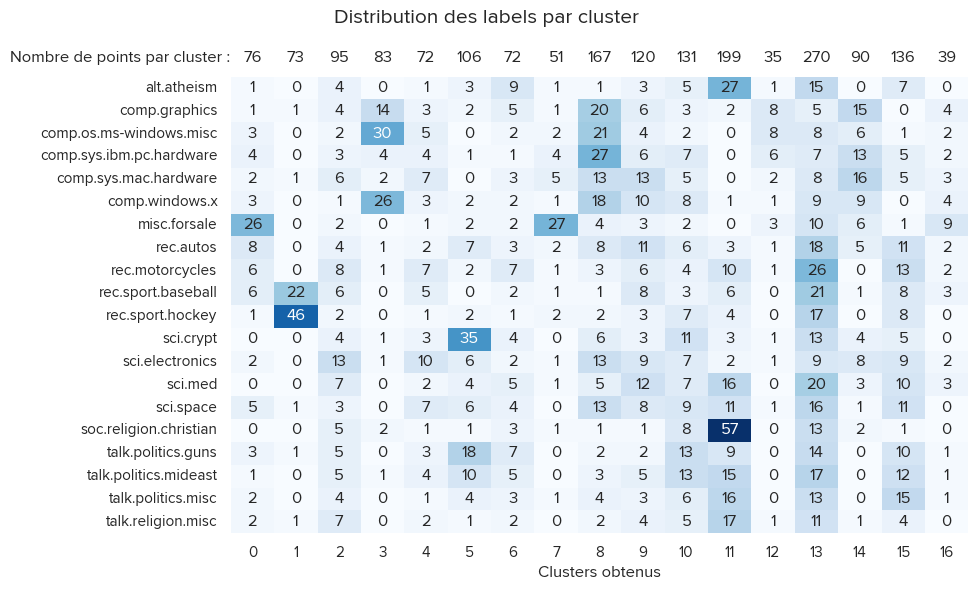

In [161]:
random.seed(1)
np.random.seed(1)

news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=True))
model = PCA(n_components=bow_bin_pca, random_state=1)
m_pca = model.fit_transform(news_desc)
centroids, affectation = clust.kmoyennes(17, m_pca, 0, 1000, False)
affectation = ce.predict_label(affectation)
fig = ce.distribution_target(news_no_stopwords['target'].values, affectation, news_no_stopwords['label'].values)

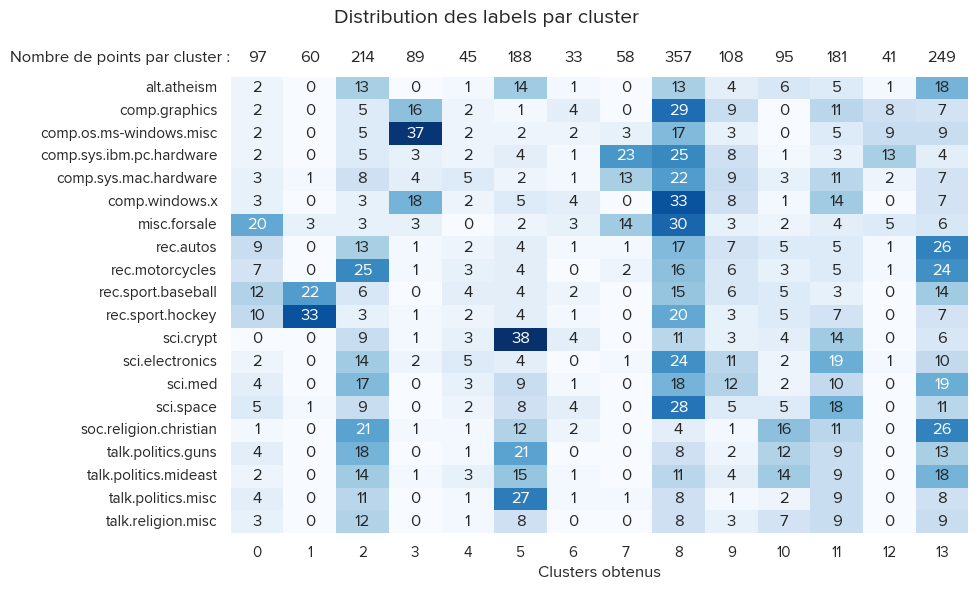

In [164]:
random.seed(1)
np.random.seed(1)

news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=False))
model = PCA(n_components=bow_non_bin_pca, random_state=1)
m_pca = model.fit_transform(news_desc)
centroids, affectation = clust.kmoyennes(14, m_pca, 0, 1000, False)
affectation = ce.predict_label(affectation)
fig = ce.distribution_target(news_no_stopwords['target'].values, affectation, news_no_stopwords['label'].values)

## Métriques en fonction de $k$ dans un algorithme K-means

In [13]:
# test sur données : 
# avec sans stop words
# bag-of-words binaire, avec fréquences, avec tfidf

# - clustering hierarchique -> regarder séparation de 2O groupes ce que ca donne visualement, modifier code pour s'arrêter à 20 groupes 
# - clustering kmeans -> 20 clusters -> matrice de repartition
# - clustering knmean -> != k pour voir combien de clusters bien
# - test sur 2 index + compacité et séparabilité

# compacité = intertie total, compacité du cluster
# séparabilité = somme distance centroid entre chaque centroid

# index de Dunn : cours : somme distance des points au centroid / dist min entre 2 clusters
# index XB : inertie total / dist min entre 2 clusters -> a voir si maxi ou non
# index Dunn 2

### Choix et définition des métriques:
Soit $k$ le nombre de clusters et $\mu_i$ le centroide d'un cluster $C_i$
- compacité : inertie globale (minimiser)
$$\sum_{i=1}^k\sum_{x\in C_i} ||x - \mu_i||²$$

- co-distance : (minimiser)
$$\sum_{i=1}^k\sum_{x\in C_i} ||x - \mu_i||$$

- séparabilité : (maximiser)
 $$\sum_{i<j} ||\mu_i - \mu_j||$$

(définition du cours)
- Xie-Beni : (minimiser)
$$ \dfrac{\text{inertie globale}}{\text{min}_{i\neq j}||\mu_i - \mu_j||}$$

- Dunn : (minimiser)
$$ \dfrac{\text{co-distance}}{\text{min}_{i\neq j}||\mu_i - \mu_j||}$$

## K-means

### Bag-of-words binaire

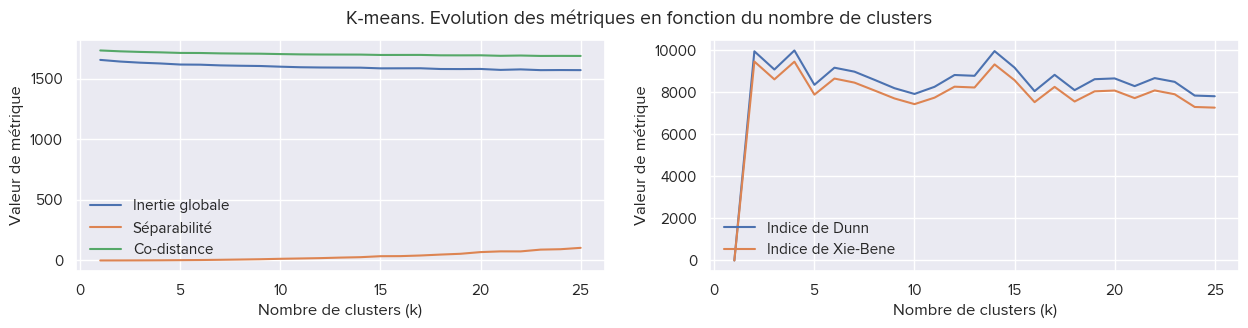

In [173]:
random.seed(1)
np.random.seed(1)
news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=True))
m_pca = PCA(n_components=bow_bin_pca, random_state=1).fit_transform(news_desc)
k_values, k_global_inertia, k_co_dist, k_separability, k_XB_index, k_Dunn_index = ce.variation_k_evalution(m_pca)
fig = ce.scores_plot("K-means. Evolution des métriques en fonction du nombre de clusters",
                  k_values, k_global_inertia, k_co_dist, k_separability, k_XB_index, k_Dunn_index)

### Bag-of-words non binaire

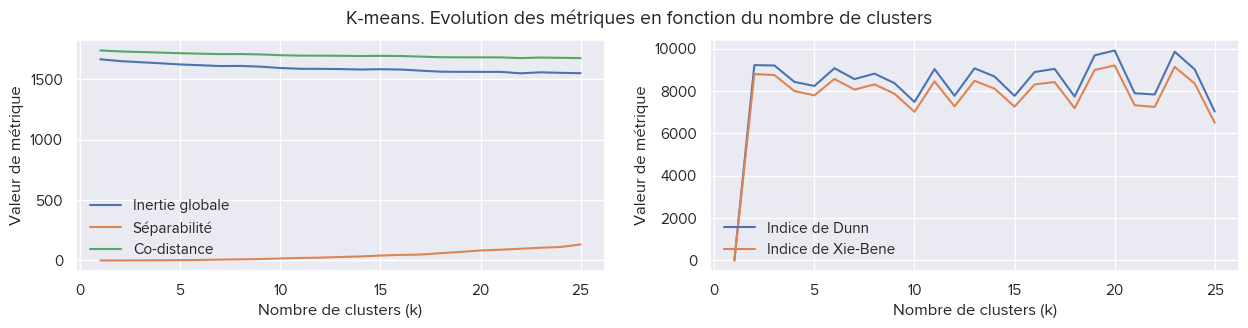

In [174]:
random.seed(1)
np.random.seed(1)

news_desc = normalize(get_bow_vect(news_no_stopwords, corpus, binary=False))
m_pca = PCA(n_components=bow_non_bin_pca, random_state=1).fit_transform(news_desc)
k_values, k_global_inertia, k_co_dist, k_separability, k_XB_index, k_Dunn_index = ce.variation_k_evalution(m_pca)
fig = ce.scores_plot("K-means. Evolution des métriques en fonction du nombre de clusters",
                  k_values, k_global_inertia, k_co_dist, k_separability, k_XB_index, k_Dunn_index)

### TF-IDF

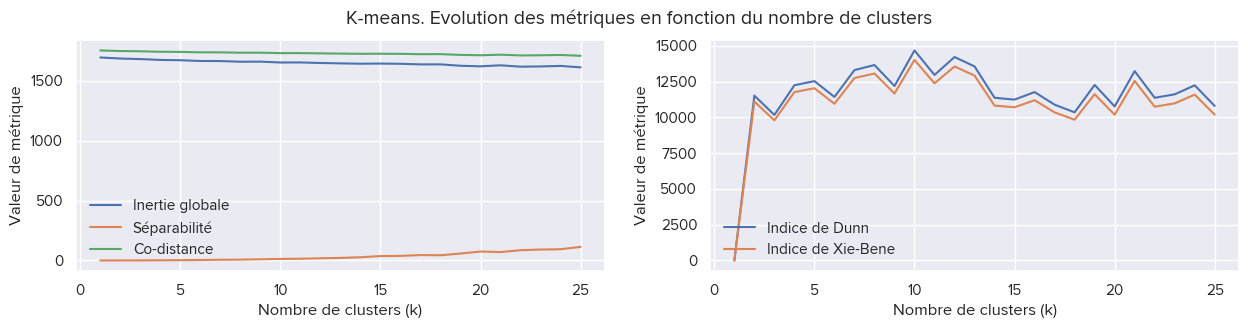

In [175]:
random.seed(1)
np.random.seed(1)

news_desc = normalize(get_tfidf_vect(news_no_stopwords, corpus))
m_pca = PCA(n_components=tfidf_pca, random_state=1).fit_transform(news_desc)
k_values, k_global_inertia, k_co_dist, k_separability, k_XB_index, k_Dunn_index = ce.variation_k_evalution(m_pca)
fig = ce.scores_plot("K-means. Evolution des métriques en fonction du nombre de clusters",
                  k_values, k_global_inertia, k_co_dist, k_separability, k_XB_index, k_Dunn_index)

Pour tous les types de vectorisation K-Means $k=18$ a eu l'une des meilleurs valeurs des indices Dunn et Xie-Bene. Par conséquent, on posera $k=18$ pour le clustering K-Means (voir la suite dans le fichier `visualization.ipynb` où on visualise aussi les données et les clusters)
***

## Clustering hierarchique

### Bag-of-Words binaire

**Remarque** : on a appliqué le clustering hiérarchique sur les vecteurs (messages) et ça prenait trop de temps. Par conséquent, on applique le clustering hierarchique sur les targets. La vectorisation des targets est obtenue en prenant les moyennes des vecteurs (messages) qui ont ce target.
On a vu également que la distance cosinus marche mieux pour la classification et en générale cette distance performe mieux pour les documents car elle regarde où pointe les vecteurs. Donc, pour les méthodes `single, complete, average` on utilise la distance cosinus, et pour `centroid` on utilise la distance euclidienne. 

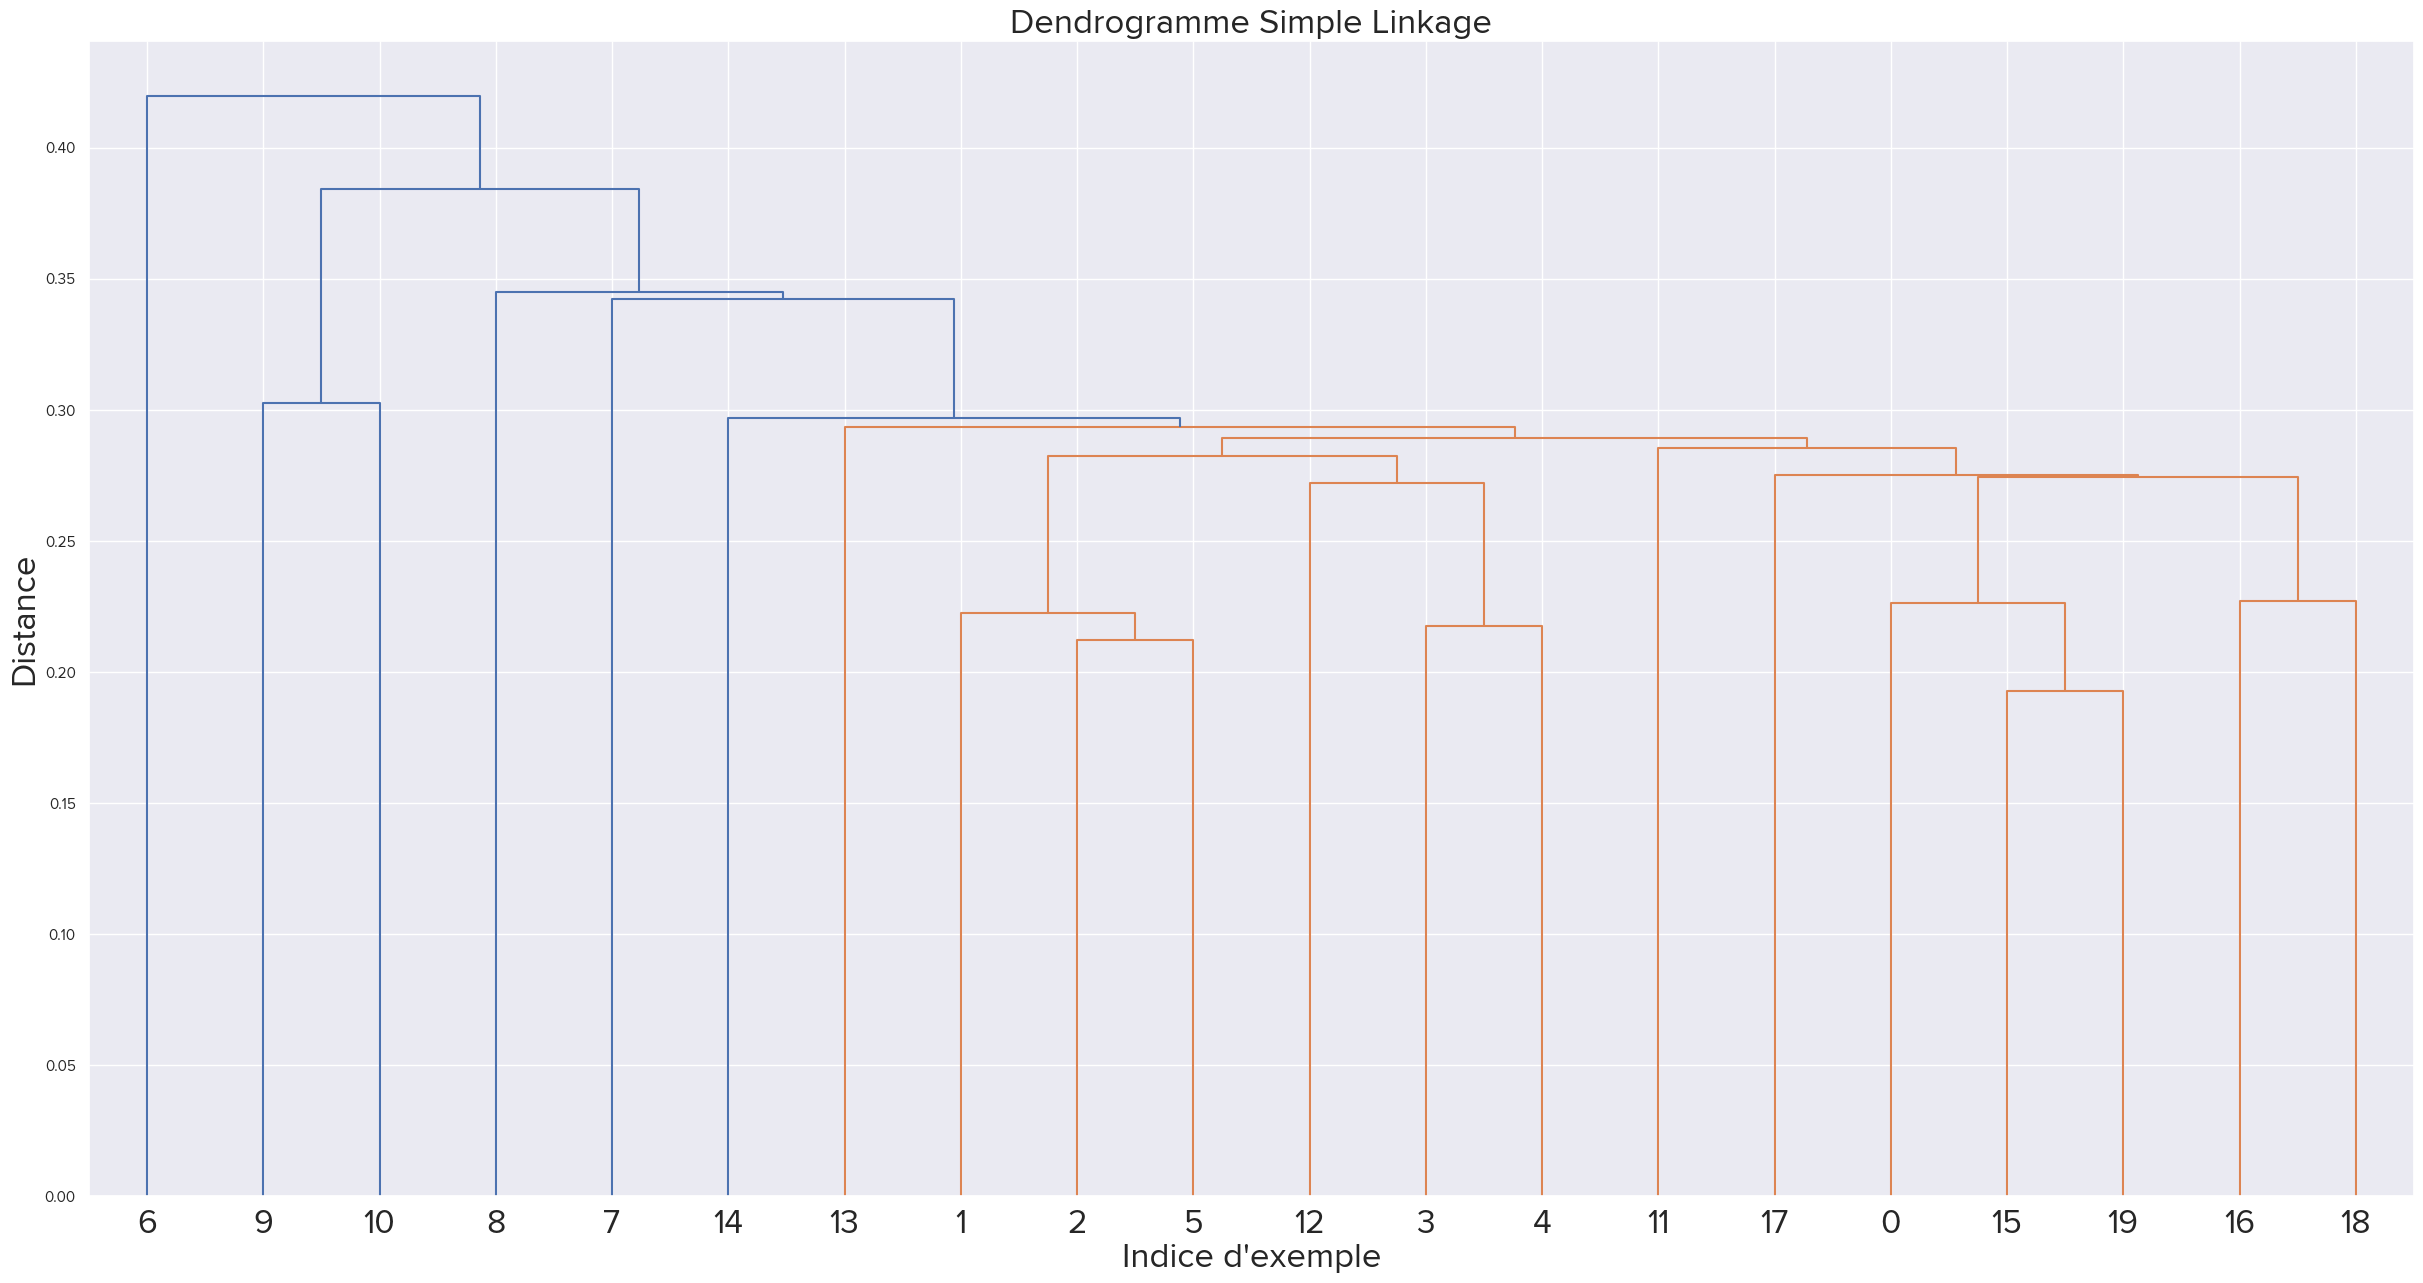

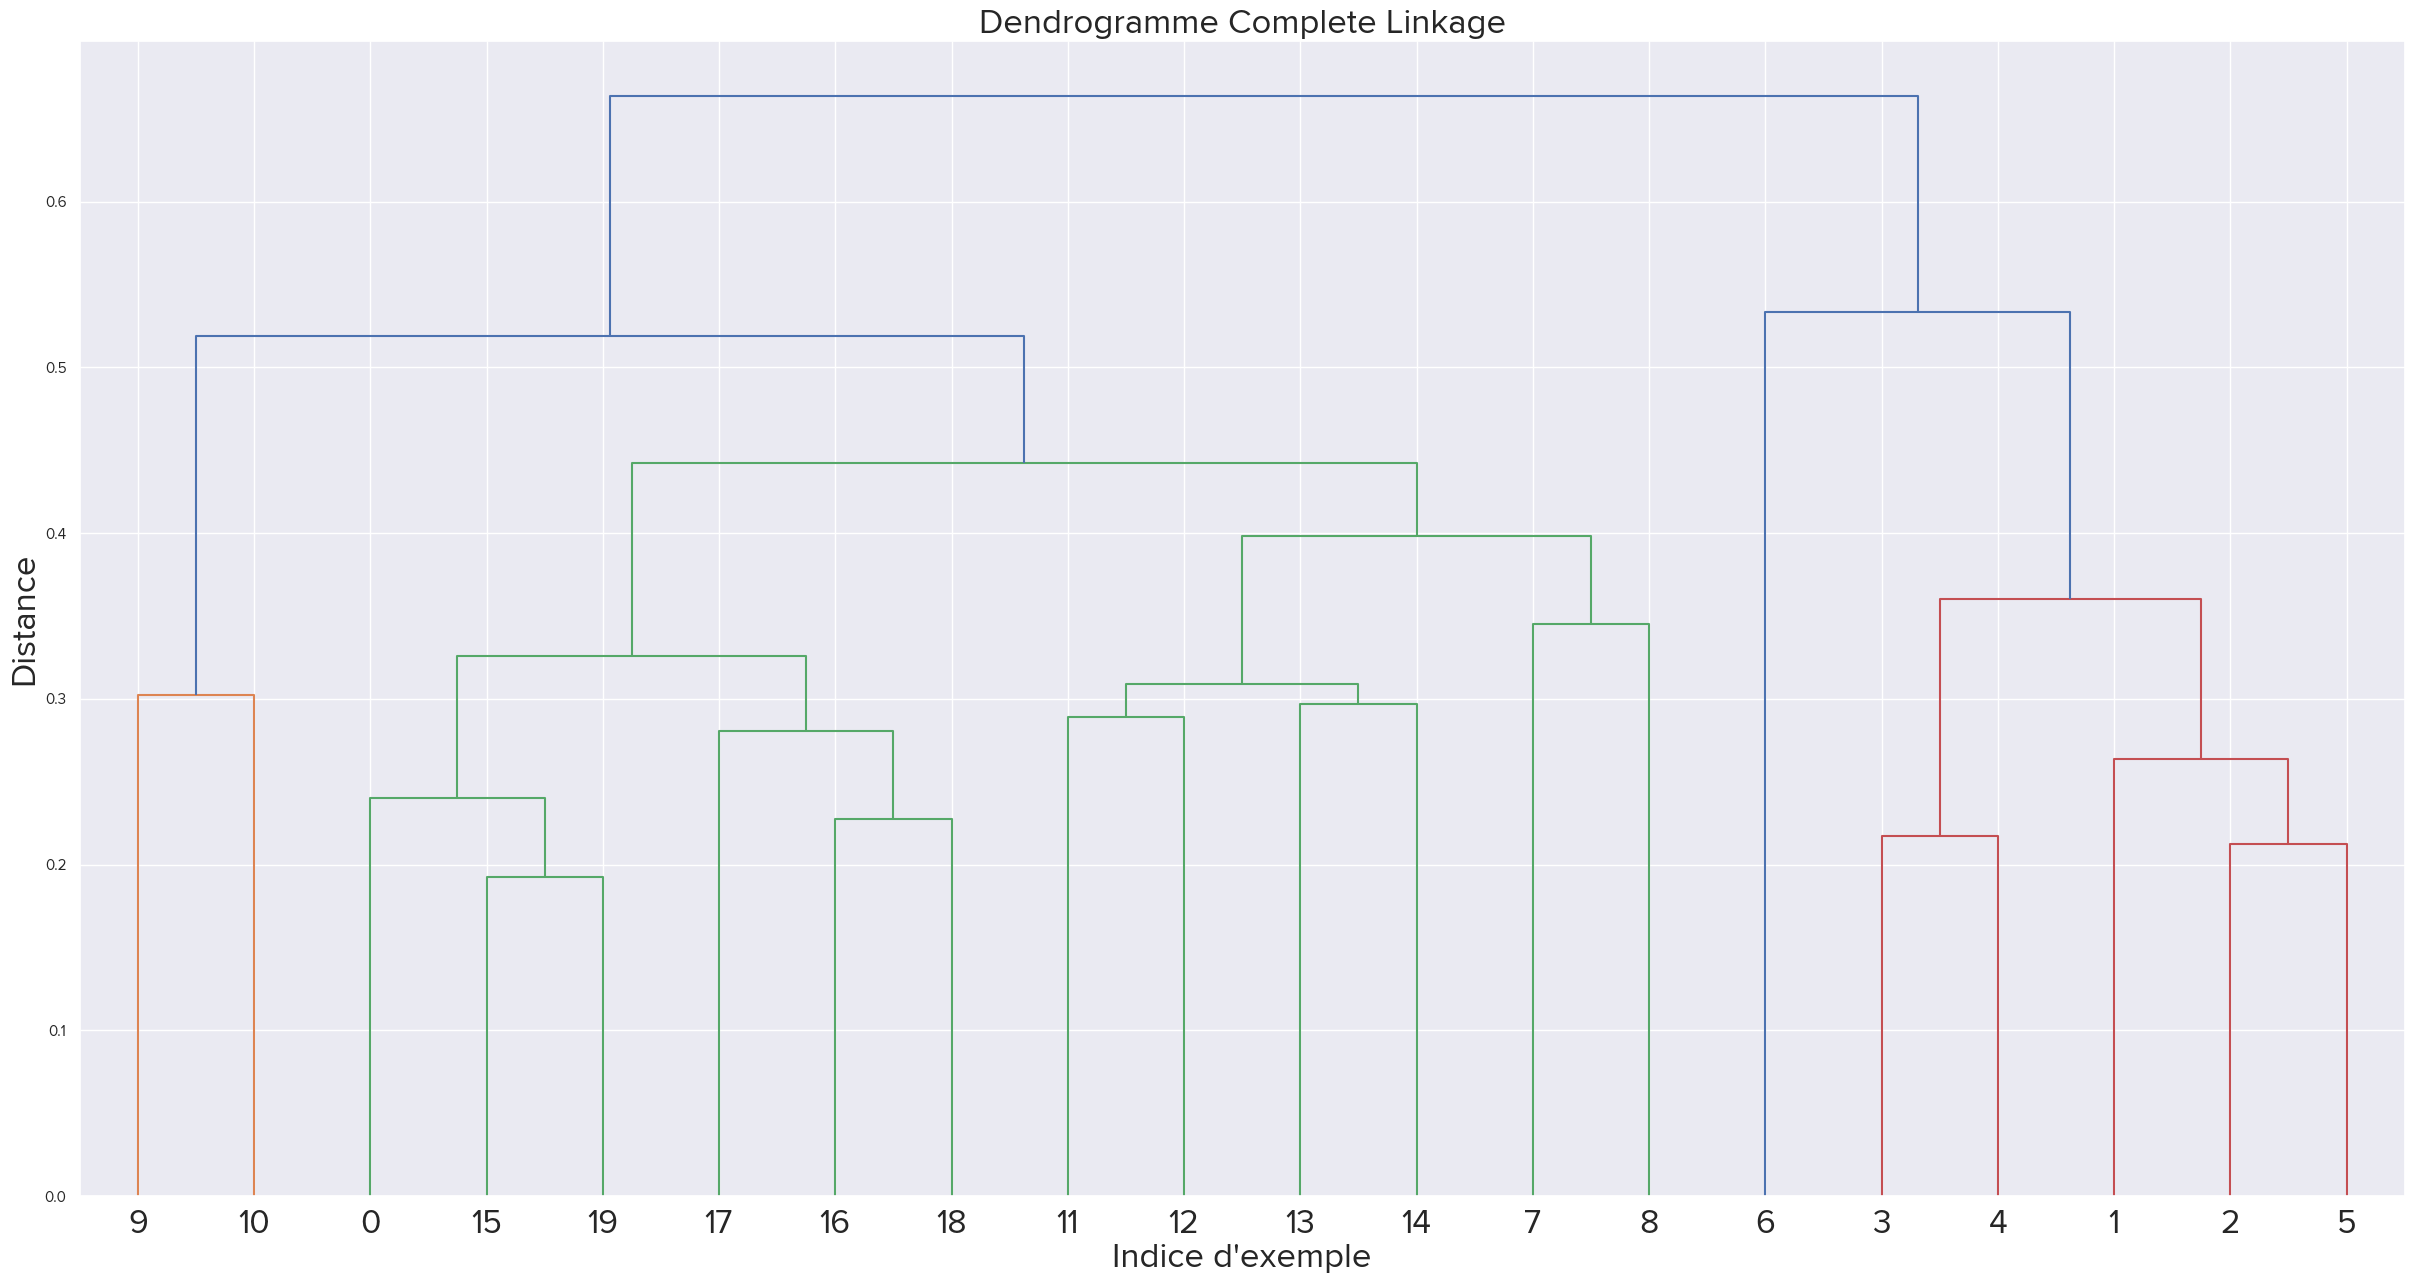

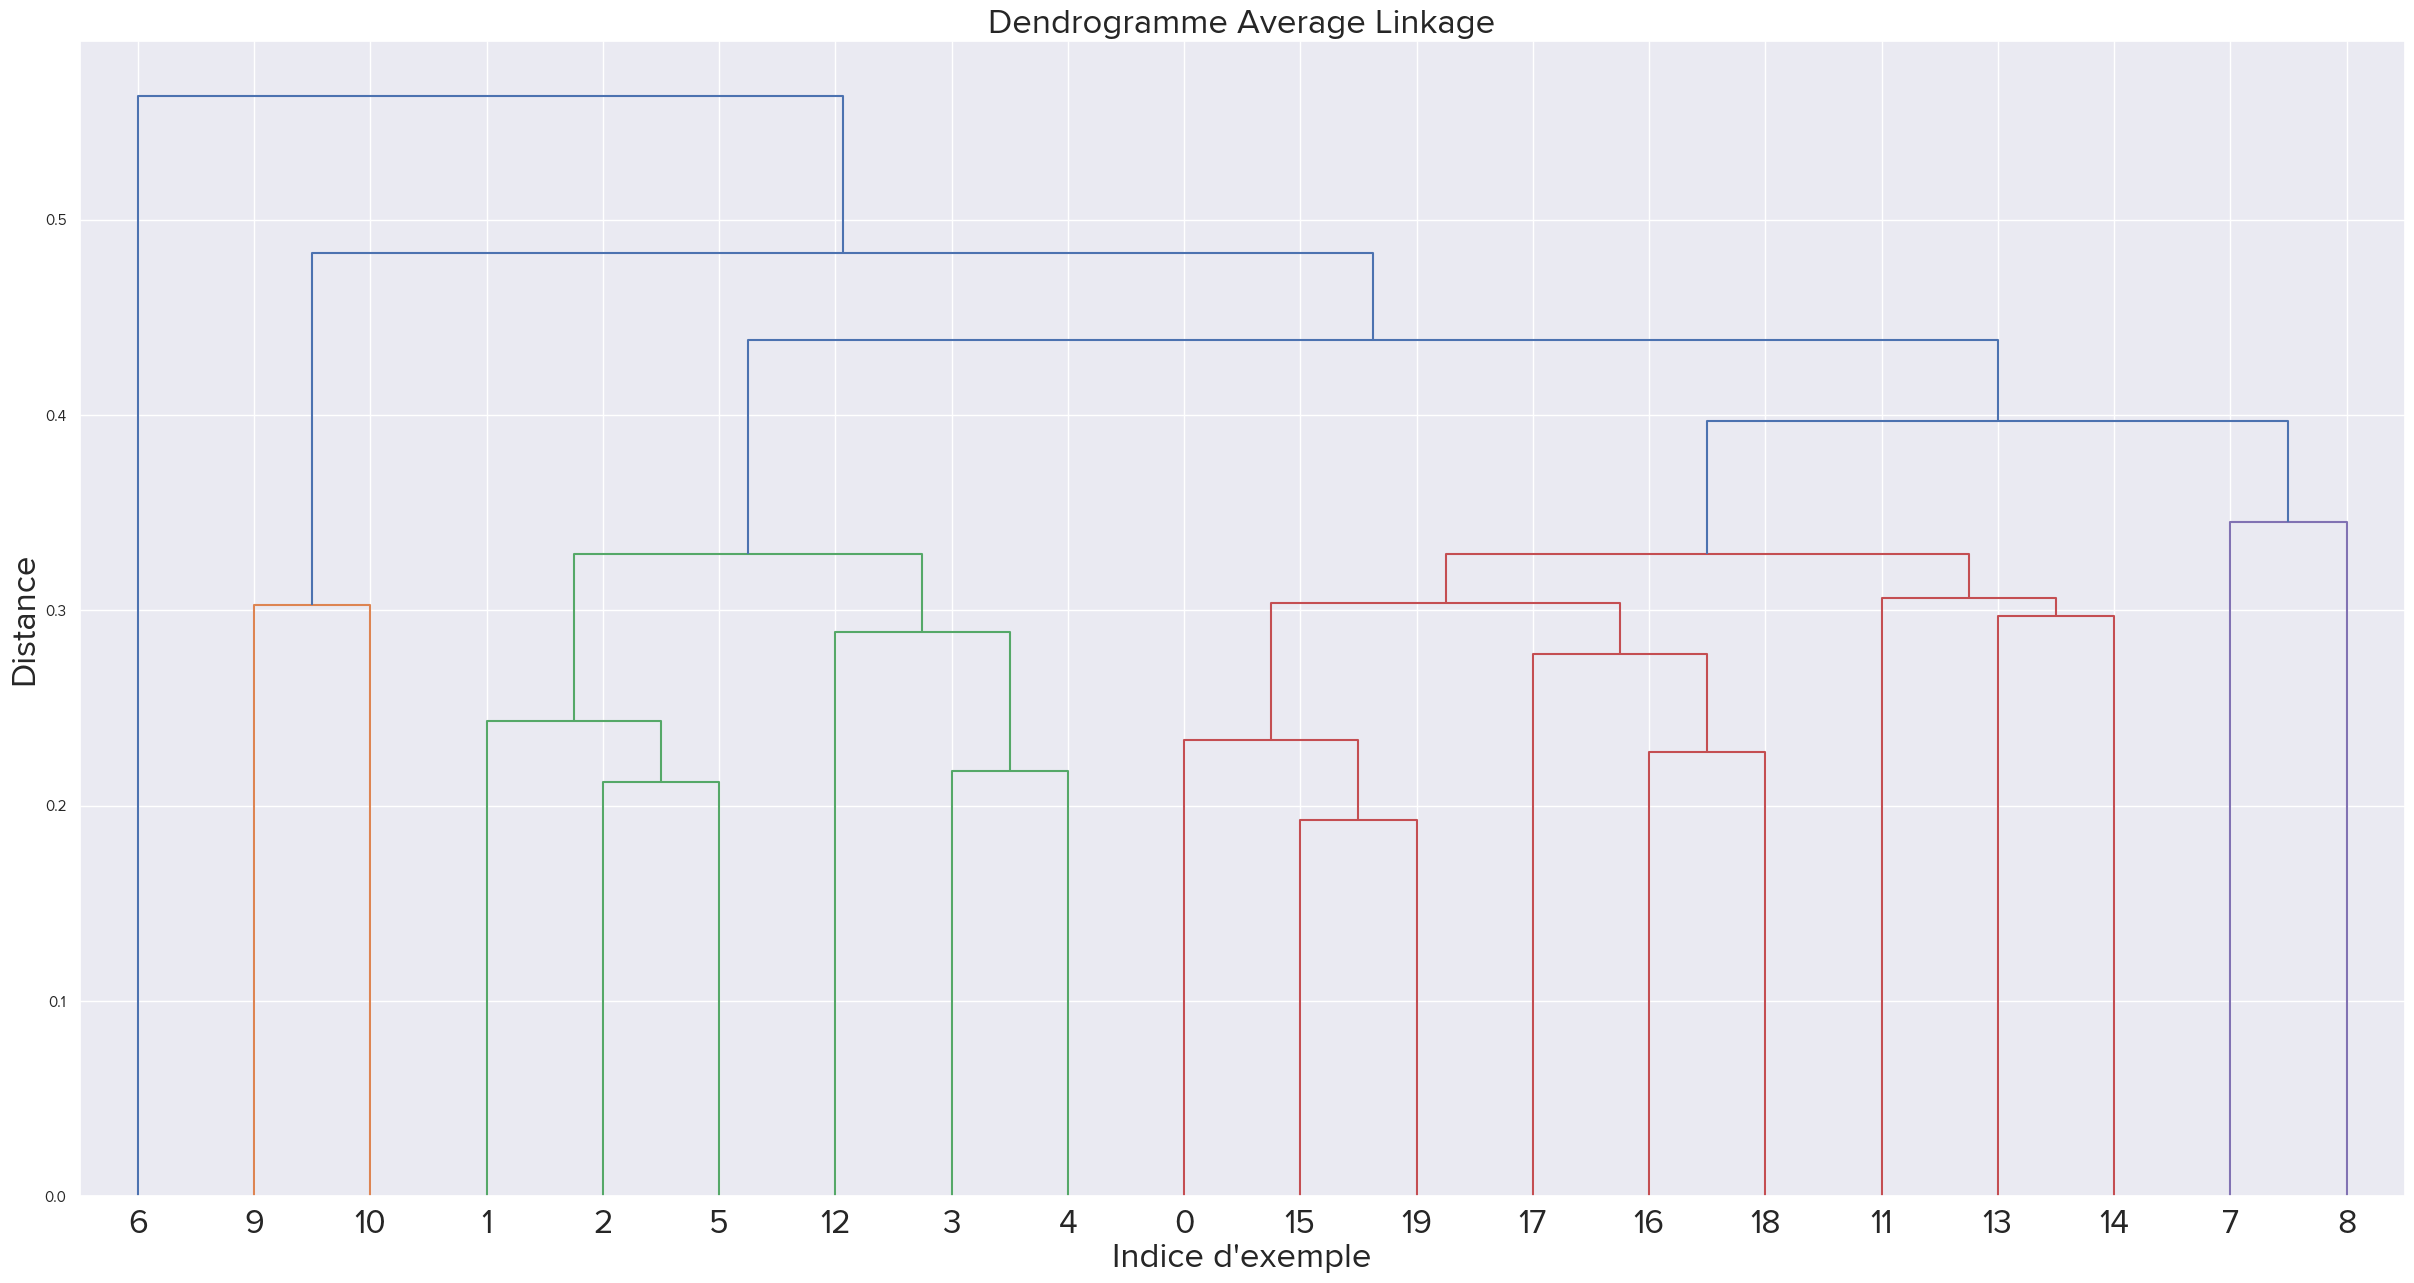

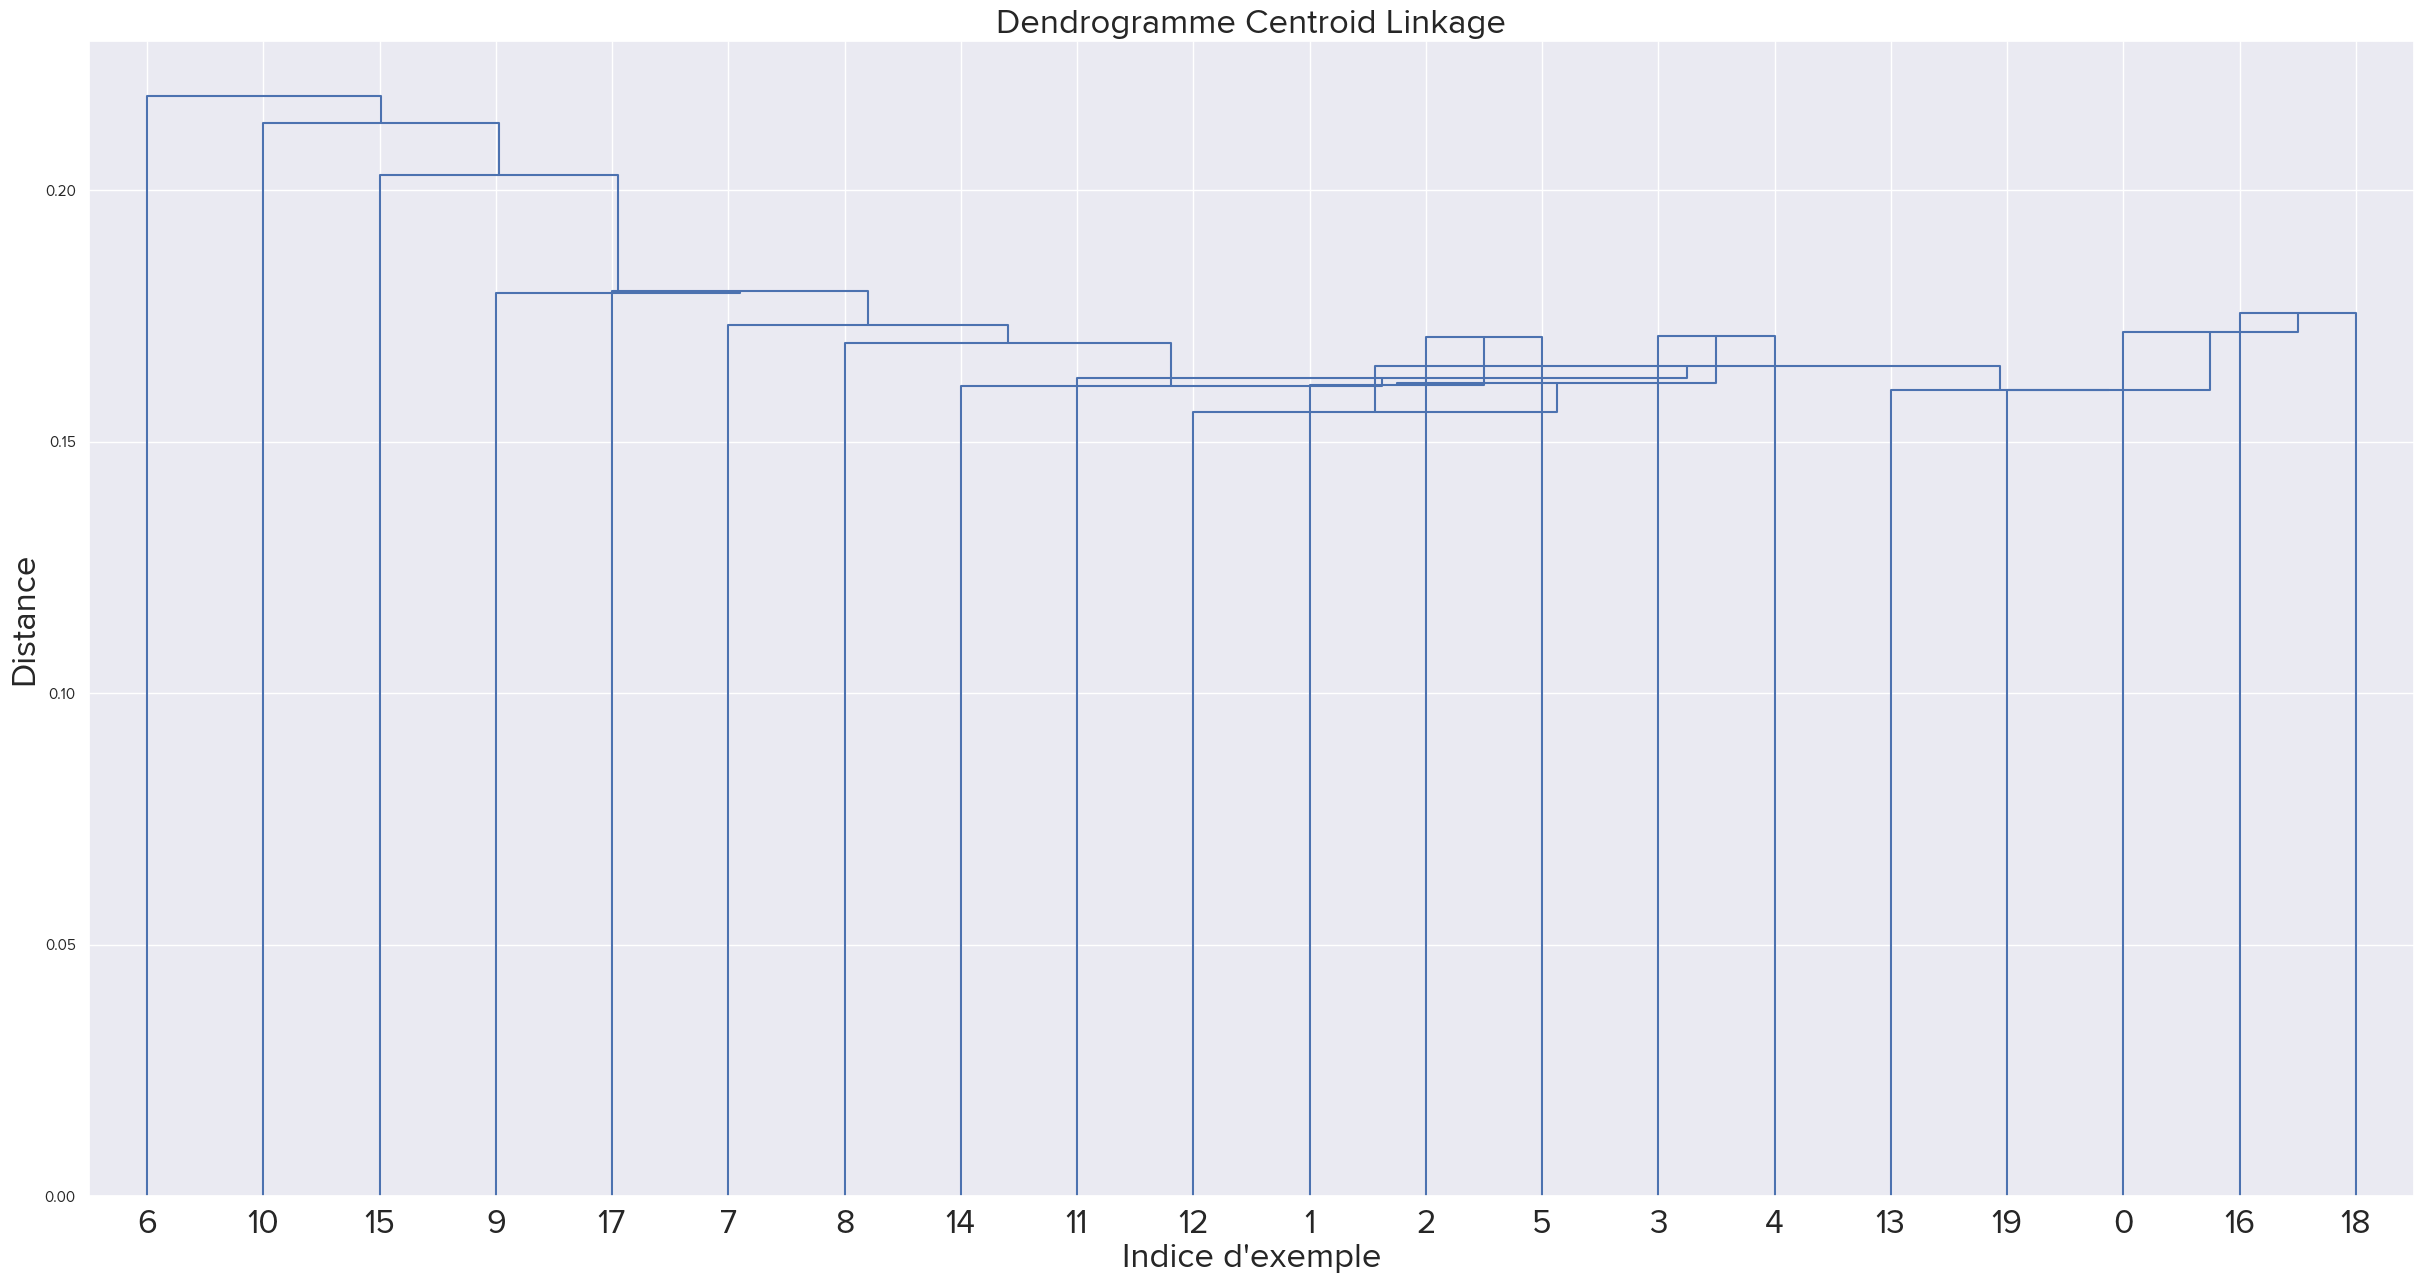

In [ ]:
news_desc = get_bow_vect(news_no_stopwords, corpus, binary=True)
targets_vectors = pd.DataFrame(ce.get_target_vectors(news_desc, news_no_stopwords))
methods = {'single':clust.CHA_simple,
           'complete':clust.CHA_complete,
           'average':clust.CHA_average,
            'centroid':clust.CHA_centroid}


for i, method in enumerate(methods):
    if method == "centroid":
        clust.CHA_centroid(targets_vectors, clust.dist_euclidienne, False, True)
    else:
        methods[method](targets_vectors, clust.dist_cosine, False, True)

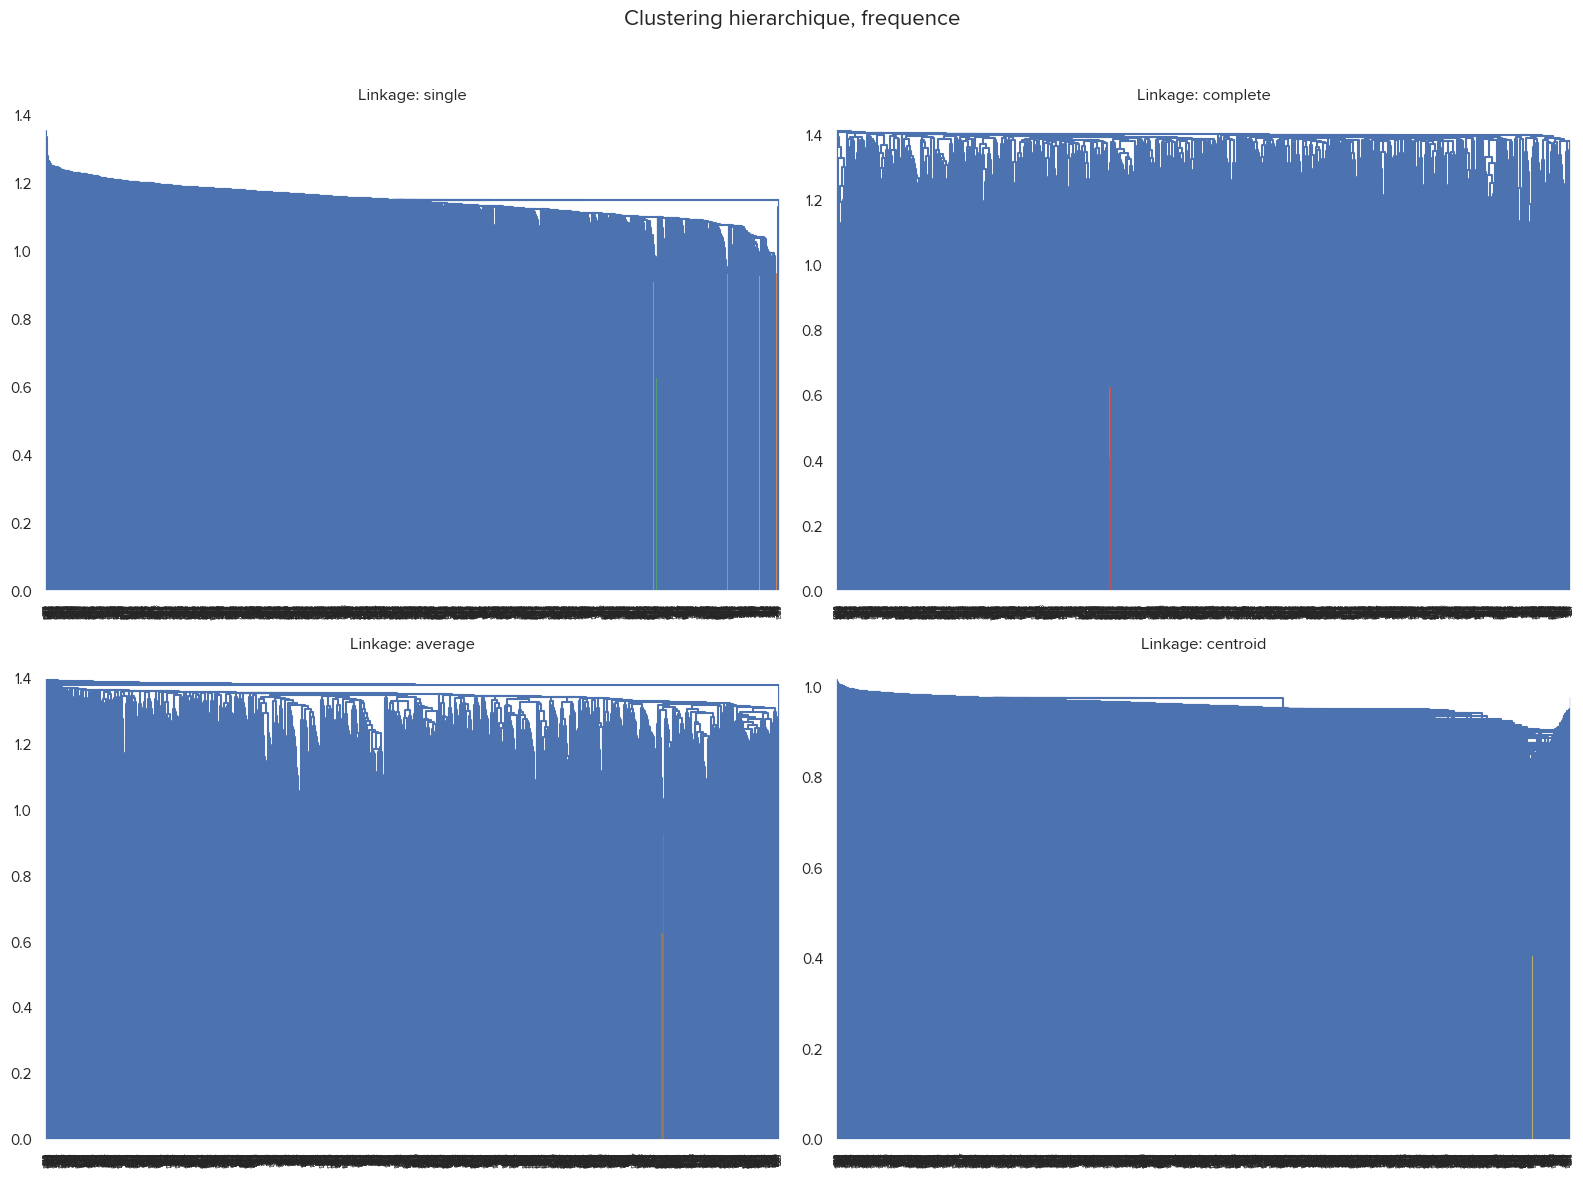

In [ ]:
methods = {'single':clust.CHA_simple,
           'complete':clust.CHA_complete,
           'average':clust.CHA_average,
            'centroid':clust.CHA_centroid}


for i, method in enumerate(methods):
    if method == "centroid":
        clust.CHA_centroid(targets_vectors, clust.dist_euclidienne, False, True)
    else:
        methods[method](targets_vectors, clust.dist_cosine, False, True)

In [16]:
# BoW binaire
news_desc = get_tfidf_vect(news_no_stopwords, corpus)
bow_no_stopw = pd.DataFrame(news_desc.todense()) # df BoW
bow_no_stopw.shape

(1815, 3012)

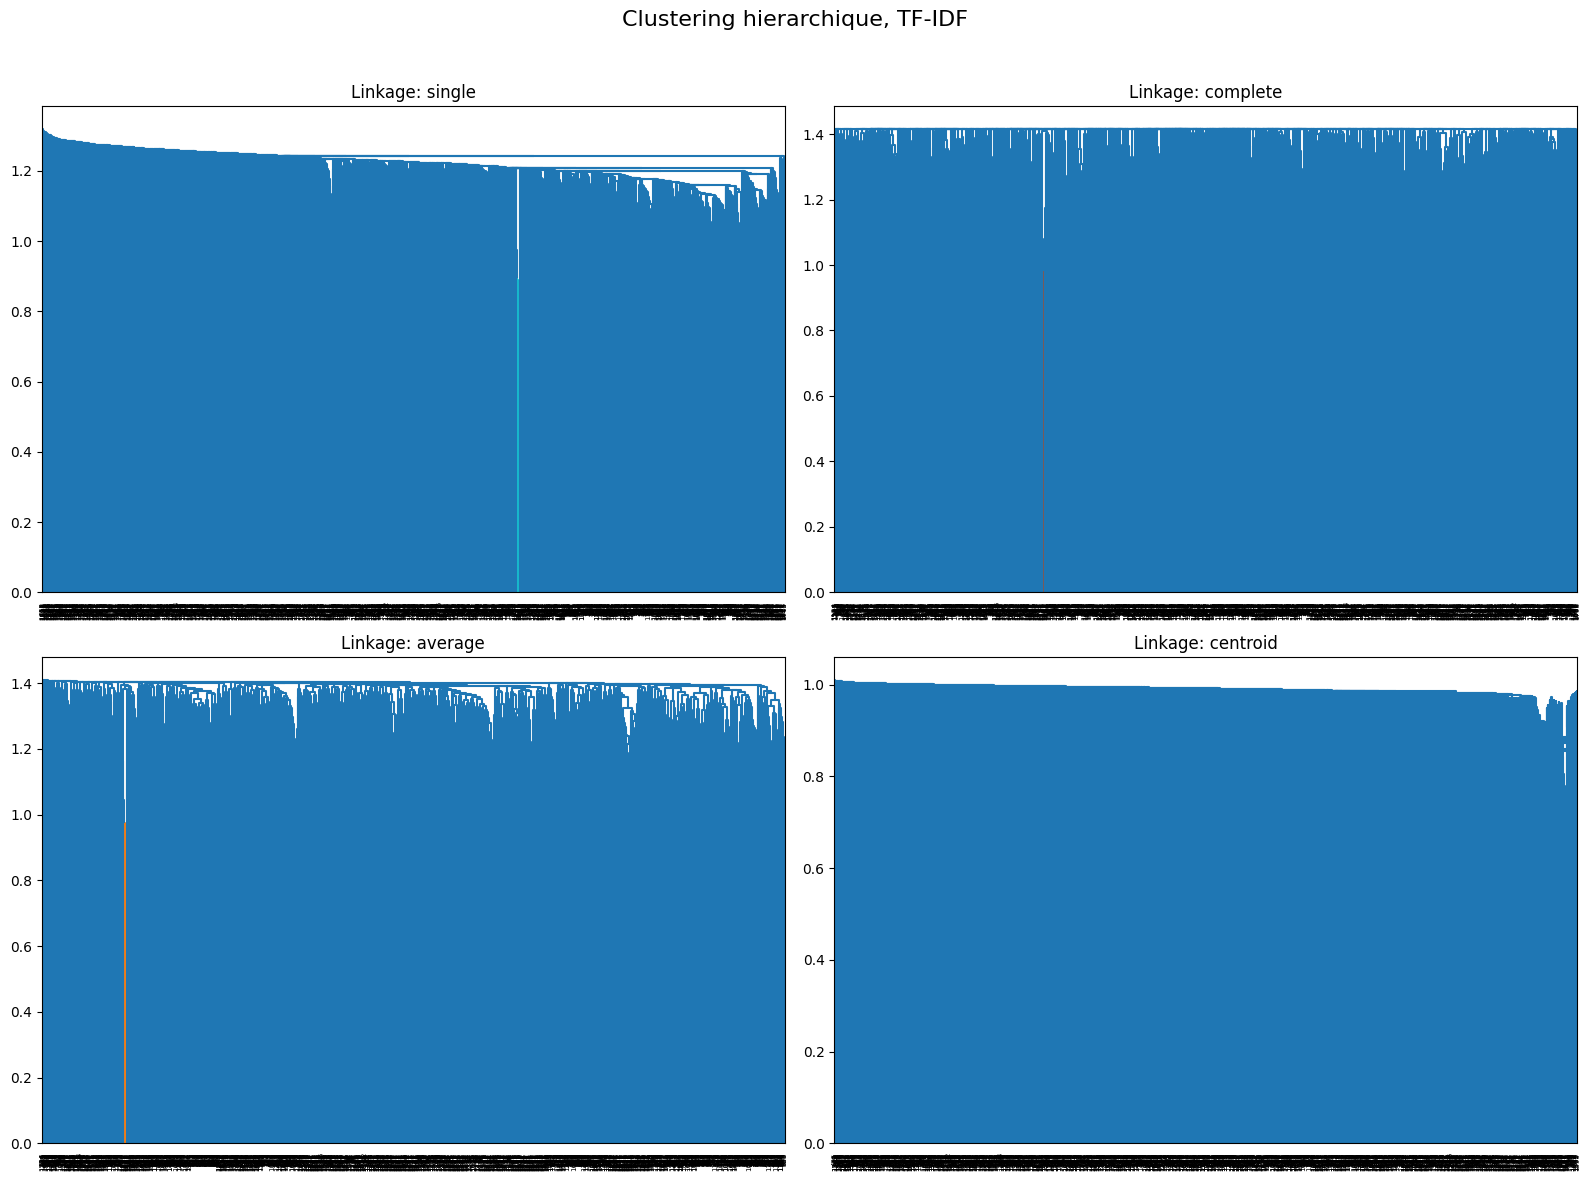

In [200]:
from scipy.cluster.hierarchy import linkage, dendrogram
methods = ['single', 'complete', 'average', 'centroid']

fig, axes = plt.subplots(2, 2, figsize=(16, 12)) 
axes = axes.flatten()

# Loop over methods and plot dendrograms
for i, method in enumerate(methods):
    linked = linkage(bow_no_stopw, method=method)
    dendrogram(linked, ax=axes[i])
    axes[i].set_title(f'Linkage: {method}')

plt.suptitle('Clustering hierarchique, TF-IDF', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle
plt.show()

---

## Tâches à réaliser

### Apprentissage supervisé

*Tâches*: évaluation d'algorithmes et de représentations des données.
- classification binaire
- classification multi-classe

*Etudes suggérées*:
- représentations des données
    - avec ou sans suppression des stopwords
    - différentes représentations: bag-of-words binaire, avec comptage, avec fréquences, avec tfidf
- différents classifiers:
    - perceptron,
    - k-plus proches voisins avec distance euclidienne,
    - k-plus proches voisins avec distance cosinus (cf. TD),
    - Naives Bayes,
    - arbres de décision
- analyse des résultats:
    - accuracy, temps d'exécutions
    - score fold par fold
    - matrice de confusion


### Apprentissage non-supervisé

*Tâche*: vérifier que le découpage a du sens par rapport aux groupes fournis. 

*Etudes suggérées*:
- étudier l'application d'un clustering hiérarchique et son résultat;
- étudier les résultats de l'application de l'algorithme des k-moyennes, pour différentes valeurs de k;
- proposer des évaluations des clusters trouvés afin de mettre en évidence les plus intéressants:
    - en utilisant les indices d'évaluation présentés en cours;
    - en comparant par diverses méthodes les clusters trouvés avec les vrais labels des classes (targets y).
- proposer une visualisation des résultats obtenus


   
